In [56]:
#Importing Packages
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.cm as mpl_cm
import seaborn as sns
import os
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

In [2]:
#Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# https://www.kaggle.com/datasets/samayashar/fraud-detection-transactions-dataset
df = pd.read_csv('data/synthetic_fraud_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [4]:
object_cols = ['Transaction_Type', 'Timestamp', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']


le = LabelEncoder()

for col in object_cols:
    df[col] = le.fit_transform(df[col])

train_df, temp_df = tts(df, test_size=0.4)
test_df, val_df = tts(temp_df, test_size=0.5)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 34426 to 3209
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                30000 non-null  object 
 1   User_ID                       30000 non-null  object 
 2   Transaction_Amount            30000 non-null  float64
 3   Transaction_Type              30000 non-null  int64  
 4   Timestamp                     30000 non-null  int64  
 5   Account_Balance               30000 non-null  float64
 6   Device_Type                   30000 non-null  int64  
 7   Location                      30000 non-null  int64  
 8   Merchant_Category             30000 non-null  int64  
 9   IP_Address_Flag               30000 non-null  int64  
 10  Previous_Fraudulent_Activity  30000 non-null  int64  
 11  Daily_Transaction_Count       30000 non-null  int64  
 12  Avg_Transaction_Amount_7d     30000 non-null  float64
 13  Fai

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 19245 to 17416
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                10000 non-null  object 
 1   User_ID                       10000 non-null  object 
 2   Transaction_Amount            10000 non-null  float64
 3   Transaction_Type              10000 non-null  int64  
 4   Timestamp                     10000 non-null  int64  
 5   Account_Balance               10000 non-null  float64
 6   Device_Type                   10000 non-null  int64  
 7   Location                      10000 non-null  int64  
 8   Merchant_Category             10000 non-null  int64  
 9   IP_Address_Flag               10000 non-null  int64  
 10  Previous_Fraudulent_Activity  10000 non-null  int64  
 11  Daily_Transaction_Count       10000 non-null  int64  
 12  Avg_Transaction_Amount_7d     10000 non-null  float64
 13  Fa

In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 48091 to 7630
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                10000 non-null  object 
 1   User_ID                       10000 non-null  object 
 2   Transaction_Amount            10000 non-null  float64
 3   Transaction_Type              10000 non-null  int64  
 4   Timestamp                     10000 non-null  int64  
 5   Account_Balance               10000 non-null  float64
 6   Device_Type                   10000 non-null  int64  
 7   Location                      10000 non-null  int64  
 8   Merchant_Category             10000 non-null  int64  
 9   IP_Address_Flag               10000 non-null  int64  
 10  Previous_Fraudulent_Activity  10000 non-null  int64  
 11  Daily_Transaction_Count       10000 non-null  int64  
 12  Avg_Transaction_Amount_7d     10000 non-null  float64
 13  Fai

In [8]:
#Collecting required features

feature_columns = ['Transaction_Amount', 'Transaction_Type', 'Account_Balance', 'Location', 'Merchant_Category', 'IP_Address_Flag','Card_Type', 'Authentication_Method', 'Daily_Transaction_Count', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Failed_Transaction_Count_7d', 'Avg_Transaction_Amount_7d', 'Previous_Fraudulent_Activity']

target = 'Fraud_Label'

X_train = train_df[feature_columns].values
y_train = train_df[target].values

#
# le = pre.LabelEncoder()
# train_df['attack_cat_encoded'] = le.fit_transform(train_df['attack_cat'])

X_test = test_df[feature_columns].values
y_test = test_df[target].values

X_val = val_df[feature_columns].values
y_val = val_df[target].values


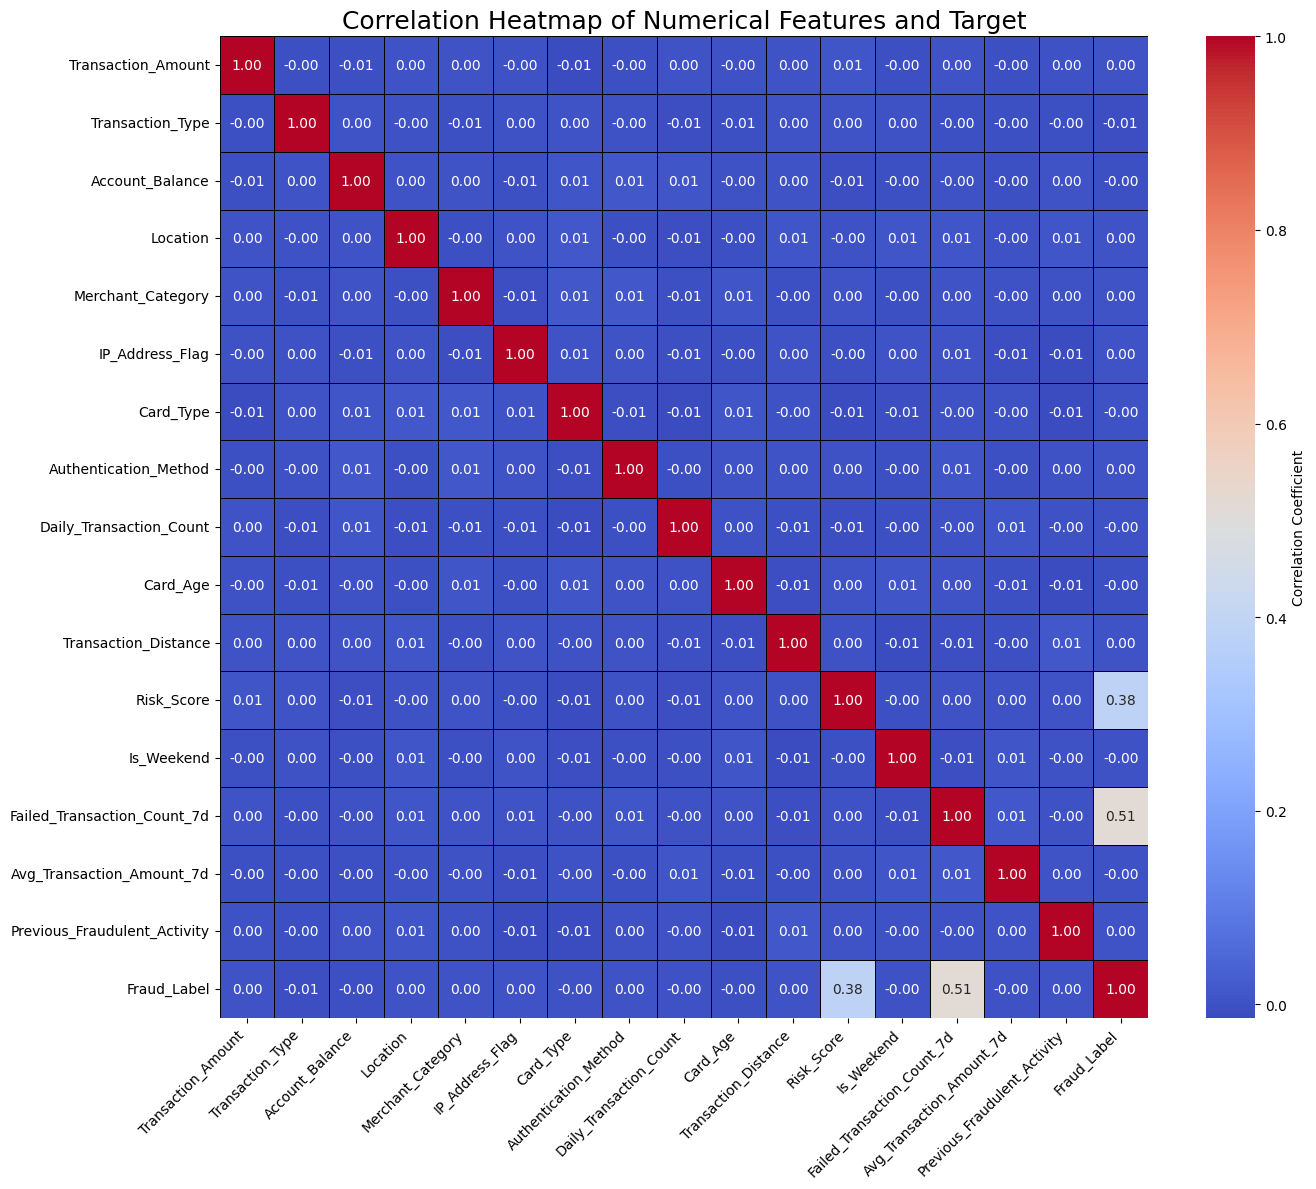

In [61]:
all_cols_for_corr = feature_columns + [target]
df_subset = train_df[all_cols_for_corr]

numerical_df = df_subset.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            linecolor='black',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Heatmap of Numerical Features and Target', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('graphs/correlation_heatmap.png', dpi=300)
plt.show()

In [10]:
#Converting to tensor
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Converting to tensor and moving to the selected device

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

In [11]:
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data loaded from CSV and prepared for PyTorch.")
print("Training data shape:", X_train_tensor.shape)
print("Test data shape:", X_test_tensor.shape)
print(f"Number of unique labels (classes): {len(np.unique(y_train))}")


Data loaded from CSV and prepared for PyTorch.
Training data shape: torch.Size([30000, 1, 16])
Test data shape: torch.Size([10000, 1, 16])
Number of unique labels (classes): 2


In [12]:
class Net1DCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(Net1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        # self.fc1 = nn.Linear(160 * 1, 64)
        # self.fc2 = nn.Linear(64, num_classes)

        with torch.no_grad():
            dummy_input = torch.randn(1, input_channels, sequence_length)
            dummy_output = self.pool1(self.relu1(self.conv1(dummy_input)))
            dummy_output = self.pool2(self.relu2(self.conv2(dummy_output)))
            flattened_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 32)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # x = self.conv2(x)
        # x = self.relu2(x)
        # x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.dropout1(x)

        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        return x


In [13]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = Net1DCNN(input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.001)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)

num_epochs = 20
taccuracy_1dcnn = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    # scheduler.step(train_accuracy)
    taccuracy_1dcnn.append(train_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")

#Metrics
all_preds_cnn = []
all_probs_cnn = []
all_labels_cnn = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        all_preds_cnn.extend(predicted.cpu().numpy())
        all_probs_cnn.extend(probs.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

all_preds_cnn = np.array(all_preds_cnn)
all_labels_cnn = np.array(all_labels_cnn)
all_probs_cnn = np.array(all_probs_cnn)



Starting model training...
Epoch [1/20], Loss: 0.6140, Train Accuracy: 73.66%
Epoch [2/20], Loss: 0.5448, Train Accuracy: 76.78%
Epoch [3/20], Loss: 0.5098, Train Accuracy: 78.33%
Epoch [4/20], Loss: 0.4912, Train Accuracy: 79.78%
Epoch [5/20], Loss: 0.4786, Train Accuracy: 81.38%
Epoch [6/20], Loss: 0.4643, Train Accuracy: 82.62%
Epoch [7/20], Loss: 0.4455, Train Accuracy: 83.75%
Epoch [8/20], Loss: 0.4360, Train Accuracy: 84.94%
Epoch [9/20], Loss: 0.4268, Train Accuracy: 86.09%
Epoch [10/20], Loss: 0.4123, Train Accuracy: 87.17%
Epoch [11/20], Loss: 0.4011, Train Accuracy: 88.10%
Epoch [12/20], Loss: 0.3895, Train Accuracy: 89.28%
Epoch [13/20], Loss: 0.3782, Train Accuracy: 90.14%
Epoch [14/20], Loss: 0.3651, Train Accuracy: 91.16%
Epoch [15/20], Loss: 0.3545, Train Accuracy: 92.28%
Epoch [16/20], Loss: 0.3421, Train Accuracy: 92.68%
Epoch [17/20], Loss: 0.3339, Train Accuracy: 93.47%
Epoch [18/20], Loss: 0.3263, Train Accuracy: 94.28%
Epoch [19/20], Loss: 0.3166, Train Accuracy: 

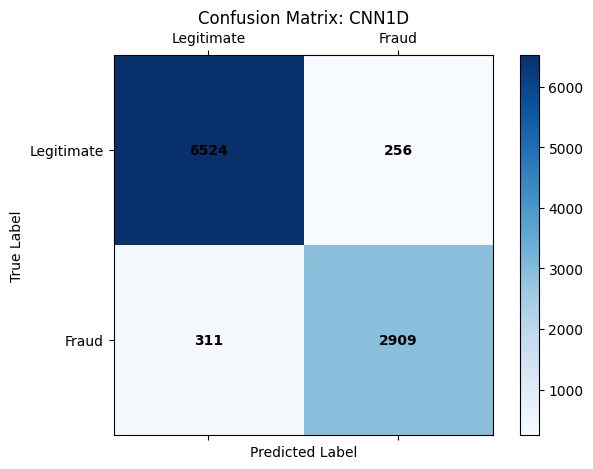

In [64]:
cmap = plt.get_cmap('Blues')

cm = confusion_matrix(all_labels_cnn, all_preds_cnn)

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=cmap)

class_labels = ['Legitimate', 'Fraud']
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)



for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='black', fontsize=10, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: CNN1D')
plt.colorbar(im)
plt.tight_layout()
plt.savefig('./graphs/cm_cnn1d.png')
plt.show()

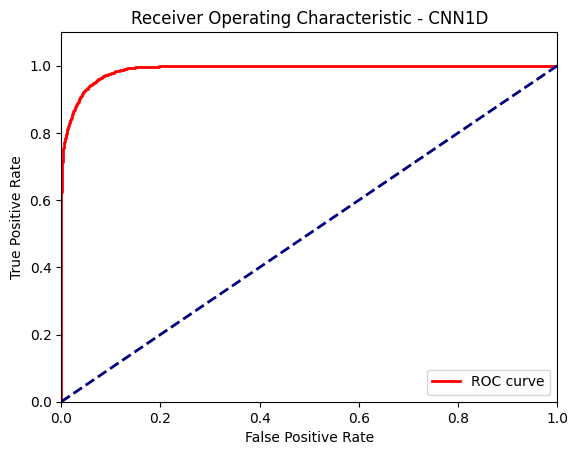

In [55]:
fpr, tpr, thresholds = roc_curve(all_labels_cnn, all_probs_cnn[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="red", lw=2, label=f"ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - CNN1D")
plt.legend(loc="lower right")
plt.savefig('./graphs/roc_cnn1d.png')
plt.show()

In [17]:
class NetLSTM(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_size=32, dropout=0.2):
        super(NetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size,
                            num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, (hn, cn) = self.lstm(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [23]:
input_channels = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

model = NetLSTM (input_channels=input_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.00008)
# optimizer = optim.SGD(model.parameters(), lr=0.0045, momentum=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)


num_epochs = 20
taccuracy_lstm = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    taccuracy_lstm.append(train_accuracy)
    scheduler.step(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")

#Metrics
all_preds_lstm = []
all_probs_lstm= []
all_labels_lstm = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        all_preds_lstm.extend(predicted.cpu().numpy())
        all_probs_lstm.extend(probs.cpu().numpy())
        all_labels_lstm.extend(labels.cpu().numpy())

all_preds_lstm = np.array(all_preds_lstm)
all_labels_lstm = np.array(all_labels_lstm)
all_probs_lstm = np.array(all_probs_lstm)


Starting model training...
Epoch [1/20], Loss: 0.6380, Train Accuracy: 68.86%
Epoch [2/20], Loss: 0.5740, Train Accuracy: 72.68%
Epoch [3/20], Loss: 0.5392, Train Accuracy: 73.20%
Epoch [4/20], Loss: 0.5287, Train Accuracy: 72.93%
Epoch [5/20], Loss: 0.5203, Train Accuracy: 73.49%
Epoch [6/20], Loss: 0.5127, Train Accuracy: 73.79%
Epoch [7/20], Loss: 0.5051, Train Accuracy: 73.82%
Epoch [8/20], Loss: 0.4992, Train Accuracy: 73.82%
Epoch [9/20], Loss: 0.4934, Train Accuracy: 73.99%
Epoch [10/20], Loss: 0.4877, Train Accuracy: 74.07%
Epoch [11/20], Loss: 0.4817, Train Accuracy: 73.79%
Epoch [12/20], Loss: 0.4754, Train Accuracy: 74.21%
Epoch [13/20], Loss: 0.4666, Train Accuracy: 74.72%
Epoch [14/20], Loss: 0.4563, Train Accuracy: 74.97%
Epoch [15/20], Loss: 0.4416, Train Accuracy: 76.52%
Epoch [16/20], Loss: 0.4225, Train Accuracy: 78.93%
Epoch [17/20], Loss: 0.3968, Train Accuracy: 83.64%
Epoch [18/20], Loss: 0.3581, Train Accuracy: 86.82%
Epoch [19/20], Loss: 0.3084, Train Accuracy: 

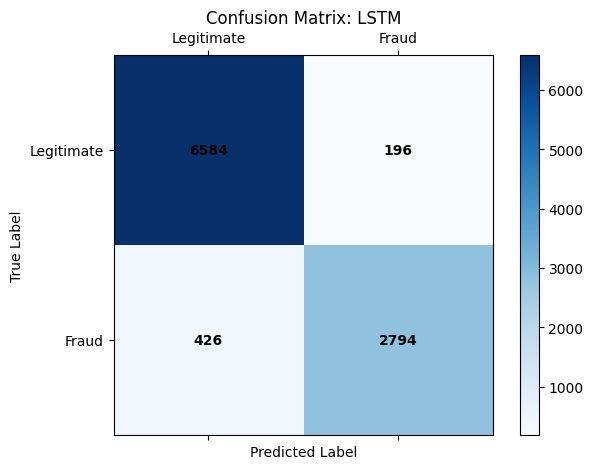

In [65]:
cmap = plt.get_cmap('Blues')

cm = confusion_matrix(all_labels_lstm, all_preds_lstm)

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=cmap)

class_labels = ['Legitimate', 'Fraud']
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)



for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='black', fontsize=10, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: LSTM')
plt.colorbar(im)
plt.tight_layout()
plt.savefig('./graphs/cm_lstm.png')
plt.show()

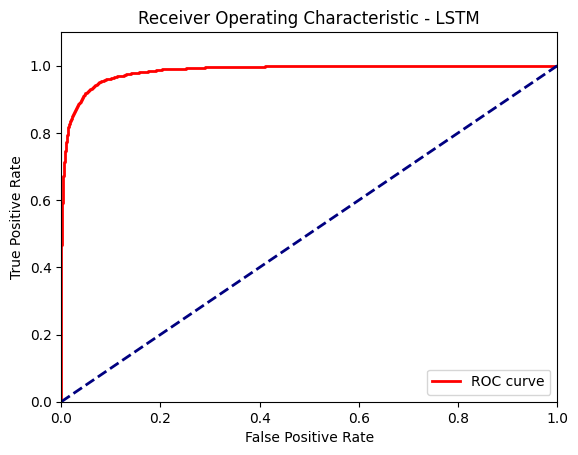

In [52]:
fpr, tpr, thresholds = roc_curve(all_labels_lstm, all_probs_lstm[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="red", lw=2, label=f"ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - LSTM")
plt.legend(loc="lower right")
plt.savefig('./graphs/roc_lstm.png')
plt.show()

In [26]:
class NetGRU(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_size=128, dropout=0.2):
        super(NetGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 3

        self.gru = nn.GRU(input_size=input_channels, hidden_size=hidden_size,
                          num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, hn = self.gru(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [28]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = NetGRU (input_channels=input_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0000175)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=3)

num_epochs = 20

taccuracy_gru = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    scheduler.step(train_accuracy)

    taccuracy_gru.append(train_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


#Metrics
all_preds_gru = []
all_probs_gru = []
all_labels_gru = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        all_preds_gru.extend(predicted.cpu().numpy())
        all_probs_gru.extend(probs.cpu().numpy())
        all_labels_gru.extend(labels.cpu().numpy())

all_preds_gru = np.array(all_preds_gru)
all_labels_gru = np.array(all_labels_gru)
all_probs_gru = np.array(all_probs_gru)



Starting model training...
Epoch [1/20], Loss: 0.6242, Train Accuracy: 69.30%
Epoch [2/20], Loss: 0.5557, Train Accuracy: 73.05%
Epoch [3/20], Loss: 0.5318, Train Accuracy: 73.32%
Epoch [4/20], Loss: 0.5248, Train Accuracy: 73.13%
Epoch [5/20], Loss: 0.5192, Train Accuracy: 73.25%
Epoch [6/20], Loss: 0.5131, Train Accuracy: 73.43%
Epoch [7/20], Loss: 0.5060, Train Accuracy: 73.45%
Epoch [8/20], Loss: 0.4991, Train Accuracy: 73.70%
Epoch [9/20], Loss: 0.4934, Train Accuracy: 73.66%
Epoch [10/20], Loss: 0.4869, Train Accuracy: 73.72%
Epoch [11/20], Loss: 0.4804, Train Accuracy: 73.77%
Epoch [12/20], Loss: 0.4723, Train Accuracy: 73.84%
Epoch [13/20], Loss: 0.4624, Train Accuracy: 74.33%
Epoch [14/20], Loss: 0.4474, Train Accuracy: 76.07%
Epoch [15/20], Loss: 0.4251, Train Accuracy: 79.13%
Epoch [16/20], Loss: 0.3901, Train Accuracy: 82.83%
Epoch [17/20], Loss: 0.3370, Train Accuracy: 87.48%
Epoch [18/20], Loss: 0.2599, Train Accuracy: 92.49%
Epoch [19/20], Loss: 0.1890, Train Accuracy: 

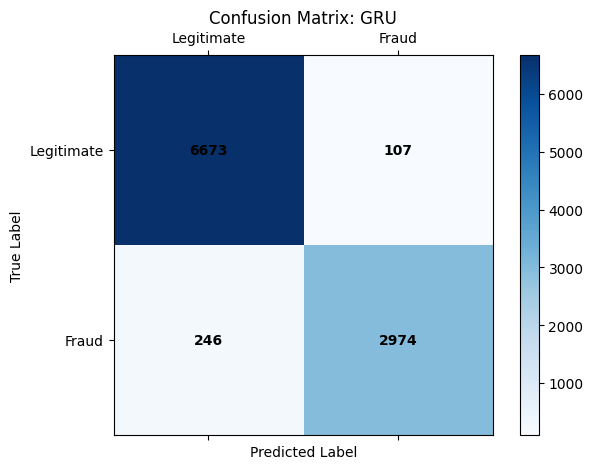

In [66]:
cmap = plt.get_cmap('Blues')

cm = confusion_matrix(all_labels_gru, all_preds_gru)

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=cmap)

class_labels = ['Legitimate', 'Fraud']
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)



for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='black', fontsize=10, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: GRU')
plt.colorbar(im)
plt.tight_layout()
plt.savefig('./graphs/cm_gru.png')
plt.show()

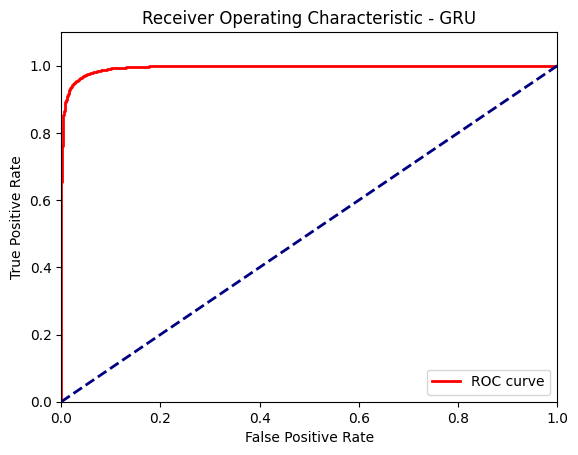

In [50]:
fpr, tpr, thresholds = roc_curve(all_labels_gru, all_probs_gru[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="red", lw=2, label=f"ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - GRU")
plt.legend(loc="lower right")
plt.savefig('./graphs/roc_gru.png')
plt.show()

In [ ]:
class TransformerNet(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.feature_embeddings = nn.Linear(num_features, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.classification_head = nn.Linear(d_model, 1)

    def forward(self, x):

        x = self.feature_embeddings(x)
        x = x + self.positional_encoding[:, :x.size(1), :]

        transformer_output = self.transformer_encoder(x)
        pooled_output = transformer_output[:, 0, :]

        output = self.classification_head(pooled_output)
        return torch.sigmoid(output)

In [ ]:
# #For values without plot
# cmap = mpl_cm.get_cmap('Blues')
# cm = confusion_matrix(all_labels, all_preds)
# fig, ax = plt.subplots()
# im = ax.matshow(cm, cmap= cmap)
#
# norm = matplotlib.colors.Normalize(vmin=cm.min(), vmax=cm.max())
#
# print("--- Confusion Matrix Cell Colors (Grayscale) ---")
# print("Mapping: Low Value -> White, High Value -> Black")
# print("-" * 50)
#
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         cell_value = cm[i, j]
#
#         normalized_value = norm(cell_value)
#
#         rgba_color = cmap(normalized_value)
#
#         hex_color = matplotlib.colors.to_hex(rgba_color)
#
#         print(f"Cell ({i}, {j}):")
#         print(f"  Value: {cell_value}")
#         print(f"  Normalized Value (0-1): {normalized_value:.4f}")
#         print(f"  Grayscale Color (RGB): ({rgba_color[0]:.2f}, {rgba_color[1]:.2f}, {rgba_color[2]:.2f})")
#         print(f"  Grayscale Color (Hex): {hex_color}")
#         print("-" * 20)
#
# print("\n--- Summary of Expected Grayscale Appearance ---")
# print("Top-Left (3712): Light-to-Medium Gray (closer to the min value)")
# print("Top-Right (64): Very Light Gray / Close to White (very low value)")
# print("Bottom-Left (16): White / Extremely Light Gray (the lowest value)")
# print("Bottom-Right (33144): Black / Very Dark Gray (the highest value)")
# print("-" * 50)

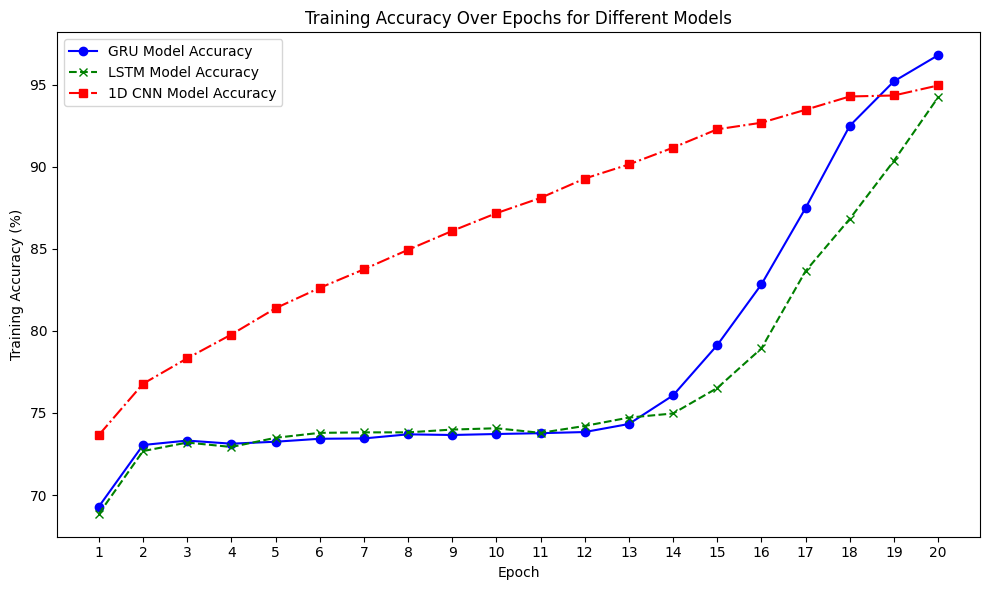

In [48]:
num_epochs = len(taccuracy_gru)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, taccuracy_gru, label='GRU Model Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(epochs, taccuracy_lstm, label='LSTM Model Accuracy', marker='x', linestyle='--', color='green')
plt.plot(epochs, taccuracy_1dcnn, label='1D CNN Model Accuracy', marker='s', linestyle='-.', color='red')

plt.title('Training Accuracy Over Epochs for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.legend()
# plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.savefig('./graphs/accuracy_vs_epoch.png')
plt.show()

In [36]:
acc_cnn = accuracy_score(all_preds_cnn, all_labels_cnn)
f1_cnn = f1_score( all_labels_cnn, all_preds_cnn, average='weighted')
pre_cnn = precision_score( all_labels_cnn, all_preds_cnn, average='weighted')
rec_cnn = recall_score( all_labels_cnn, all_preds_cnn, average='weighted')

acc_lstm = accuracy_score(all_preds_lstm, all_labels_lstm)
f1_lstm = f1_score( all_labels_lstm, all_preds_lstm, average='weighted')
pre_lstm = precision_score( all_labels_lstm, all_preds_lstm, average='weighted')
rec_lstm = recall_score( all_labels_lstm, all_preds_lstm, average='weighted')

acc_gru = accuracy_score(all_preds_gru, all_labels_gru)
f1_gru = f1_score( all_labels_gru, all_preds_gru, average='weighted')
pre_gru = precision_score( all_labels_gru, all_preds_gru, average='weighted')
rec_gru = recall_score( all_labels_gru, all_preds_gru, average='weighted')

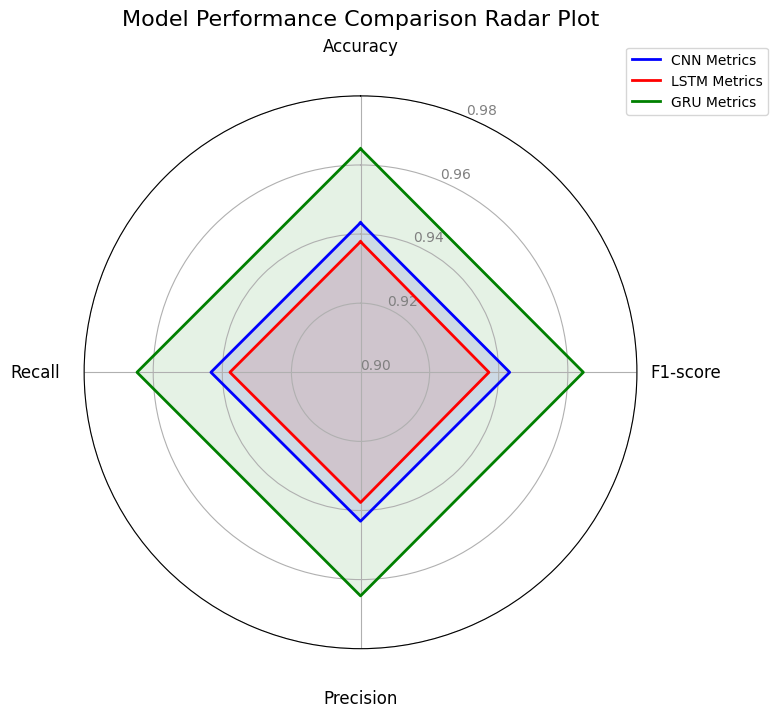

In [62]:
categories = ['Accuracy', 'F1-score', 'Precision', 'Recall']
num_vars = len(categories)

values_cnn = [acc_cnn, f1_cnn, pre_cnn, rec_cnn]
values_lstm = [acc_lstm, f1_lstm, pre_lstm, rec_lstm]
values_gru = [acc_gru, f1_gru, pre_gru, rec_gru]

values_cnn = values_cnn + [values_cnn[0]]
values_lstm = values_lstm + [values_lstm[0]]
values_gru = values_gru + [values_gru[0]]

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles = angles + [angles[0]]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values_cnn, linewidth=2, linestyle='solid', color='blue', label='CNN Metrics')
ax.fill(angles, values_cnn, 'blue', alpha=0.1)

ax.plot(angles, values_lstm, linewidth=2, linestyle='solid', color='red', label='LSTM Metrics')
ax.fill(angles, values_lstm, 'red', alpha=0.1)

ax.plot(angles, values_gru, linewidth=2, linestyle='solid', color='green', label='GRU Metrics')
ax.fill(angles, values_gru, 'green', alpha=0.1)


ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.tick_params(axis='x', pad=25)

max_val = 0.98
min_val = 0.9

radial_tick_positions = np.arange(min_val, max_val + 0.02, 0.02)
radial_tick_labels = [f'{y:.2f}' for y in radial_tick_positions]

ax.set_ylim(min_val, max_val)
ax.set_yticks(radial_tick_positions)
ax.set_yticklabels(radial_tick_labels, color='grey', size=10)

ax.set_title('Model Performance Comparison Radar Plot', va='bottom', fontsize=16)

ax.grid(True)

ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))

plt.tight_layout()

plt.savefig('graphs/metrics_radar.png')

plt.show()

In [ ]:
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'synfraud_model.pth')


torch.save(model.state_dict(), model_path)
print(f"\nModel saved to {model_path}")